# Generating time series


In this section we generate time series of a dynamical system. First, let's look at the Lorenz attractor:

$$
\dot{x} = \sigma (y - x) \\
\dot{y} = x (\rho - z) - y \\
\dot{z} = xy - \beta z
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Lorenz system
def lorenzsys(state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    v = np.array([
        sigma*(y - x),
        x*(rho - z) - y,
        x*y - beta*z
    ])
    return v

Can generate time series in the following way:

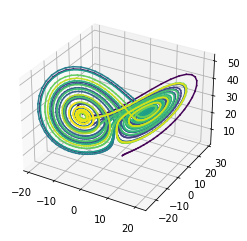

In [2]:
from dynsys import *

sys1 = DynamicalSystem(lorenzsys)

dt = 0.01
T = 50
X0 = np.array([2,2,2])

X_lorenz = sys1.timeseries(X0, dt, int(T/dt))
plot3(X_lorenz)

The system can made to be stochastic by providing the diffusion matrix, or just a single float if the noise is of the same amplitude for every variable:

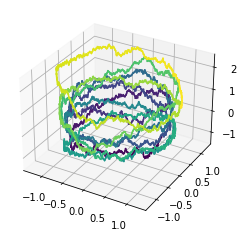

In [31]:
def xy_osc(state, k=0.1):
    x, y, z = state
    f = np.array([
        y,
        -x,
        0
    ])
    return f

X0 = np.array([1,0,0])
D = np.diag([0,0,0.5]) # Noise only in the z direction

sys2 = DynamicalSystem(xy_osc);
X_osc = sys2.timeseries(X0, dt, int(T/dt), D)
plot3(X_osc)


# Fitting the SINDy model with time series

### Polynomial basis

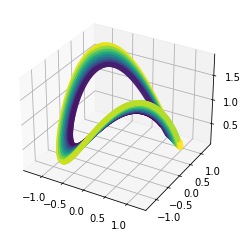

x' = 1.000 y
y' = -1.000 x
z' = 1.000 x^2 + -1.000 y^2


In [94]:
import pysindy as ps

def F(X):
    x, y, z = X
    f = np.array([
        y,
        -x,
        x**2 - y**2
    ])
    return f

dt = 0.01
T = 50
X0 = np.array([1,0,1])
dsys = DynamicalSystem(F)
X = dsys.timeseries(X0, dt, int(T/dt))

scatter3(X)

model = ps.SINDy(feature_names=["x", "y", "z"])
model.fit(X, t=dt)
model.print()

## Higher orders of polynomial basis

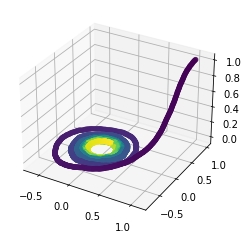

x' = 1.001 y + -0.225 x z + 0.215 x^2 z + -0.992 x y^2
y' = -1.000 x + -0.092 y z + -0.920 x^2 y
z' = -0.236 z + 1.122 x z + 0.111 y z + -2.739 z^2 + 0.069 x^2 y + 2.458 x y z + -0.707 y^2 z


In [33]:
def F(X):
    x, y, z = X
    v = np.array([
        y - x*y**2,
        -x - y*x**2,
        -z + x*y*z
    ])
    return v

X0 = np.array([1,1,1])

sys3 = DynamicalSystem(F);
X = sys3.timeseries(X0, dt, int(T/dt), D=0.01)
scatter3(X)
model = ps.SINDy(feature_names=["x", "y", "z"], feature_library = ps.PolynomialLibrary(degree = 3))
model.fit(X, t=dt)
model.print()

## Fourier basis

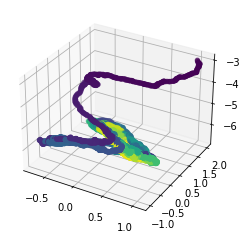

x' = 19.385 cos(1 x) + -5.973 sin(1 y) + -15.387 cos(1 y) + -4.224 sin(1 z) + -1.832 cos(1 z) + -10.127 cos(2 x) + 6.957 sin(2 y) + 8.362 cos(2 y) + 2.244 sin(2 z) + -1.985 cos(2 z) + -0.957 sin(3 x) + 3.011 cos(3 x) + -3.745 sin(3 y) + -1.694 cos(3 y) + 0.575 sin(3 z) + 1.265 cos(3 z) + 0.481 sin(4 x) + -0.434 cos(4 x) + 0.805 sin(4 y) + 0.335 cos(4 y) + -0.475 sin(4 z)
y' = -25.610 cos(1 x) + 11.562 sin(1 y) + 23.276 cos(1 y) + 2.984 sin(1 z) + 3.189 cos(1 z) + -0.165 sin(2 x) + 10.545 cos(2 x) + -14.244 sin(2 y) + -11.806 cos(2 y) + -2.985 sin(2 z) + -0.185 cos(2 z) + 0.215 sin(3 x) + -1.784 cos(3 x) + 7.675 sin(3 y) + 3.215 cos(3 y) + 1.056 sin(3 z) + -0.037 cos(3 z) + -1.750 sin(4 y) + -0.254 cos(4 y) + 0.444 cos(4 z)
z' = -0.687 cos(1 x) + 1.406 sin(1 y) + -0.217 cos(1 y) + -1.256 sin(1 z) + 0.344 cos(1 z) + 0.708 cos(2 x) + -0.901 sin(2 y) + 0.916 cos(2 y) + -0.493 cos(2 z) + 0.564 cos(3 x) + -0.606 cos(3 y) + 0.376 sin(3 z) + 0.132 cos(3 z) + 0.140 sin(4 y) + -0.219 sin(4 z)


In [30]:
def F(X):
    x, y, z = X
    v = np.array([
        -np.sin(x)+np.cos(3*y),
        -np.sin(y)+np.cos(3*z),
        -np.sin(z)+np.cos(3*x)
    ])
    return v

X0 = np.array([1,2,-3])

sys3 = DynamicalSystem(F);
X = sys3.timeseries(X0, dt, int(T/dt), D = 0)
scatter3(X)
model = ps.SINDy(feature_names=["x", "y", "z"], feature_library = ps.FourierLibrary(n_frequencies=4))
model.fit(X, t=dt)
model.print()

## Custom basis

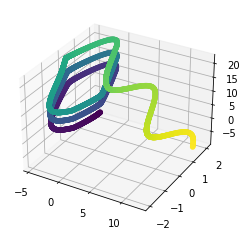

x' = 1.000 y
y' = -1.000 cos(1 x)
z' = -1.001 sign(x) + -0.998 sign(y)


In [183]:
def F(X):
    x, y, z = X
    v = np.array([
        y,
        -np.cos(x),
        -np.sign(y)-np.sign(x)
    ])
    return v

X0 = np.array([1,0,5])

custom_library = ps.PolynomialLibrary(degree = 2) +\
                 ps.FourierLibrary(n_frequencies = 2) +\
                 ps.CustomLibrary(library_functions = [lambda x: np.sign(x)], function_names = [lambda x: "sign(" + x + ")"])

sys3 = DynamicalSystem(F);
X = sys3.timeseries(X0, dt, int(T/dt))
scatter3(X)
model = ps.SINDy(feature_names=["x", "y", "z"], feature_library = custom_library)
model.fit(X, t=dt)
model.print()

## Stochastic trajectory

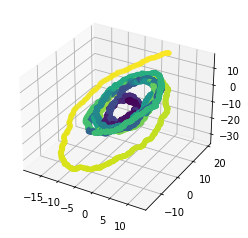

x' = 1.007 y
y' = -0.229 1 + -0.979 x
z' = -0.989 x + 1.037 y


In [119]:
def F(X):
    x, y, z = X
    v = np.array([
        y+0.2,
        -x-0.2,
        -x+y,
    ])
    return v

X0 = np.array([0,1,0])
D = 1

sys3 = DynamicalSystem(F);
X = sys3.timeseries(X0, dt, int(T/dt), D = D)
scatter3(X)
model = ps.SINDy(feature_names=["x", "y", "z"])
model.fit(X, t=dt)
model.print()

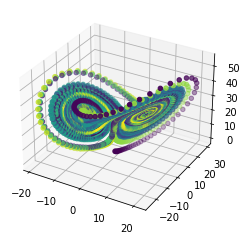

x' = -9.837 x + 9.971 y
y' = 25.269 x + 0.275 y + -0.946 x z
z' = -10.855 1 + -2.221 z + 0.997 x y


In [122]:
sys3 = DynamicalSystem(lorenzsys)
D = .5
X = sys3.timeseries(X0, dt, int(T/dt), D = D)
scatter3(X)
model = ps.SINDy(feature_names=["x", "y", "z"])
model.fit(X, t=dt)
model.print()

# Stochastic algorithm

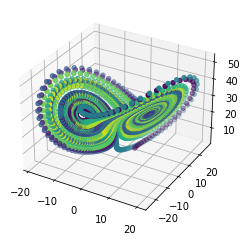

In [23]:
from stochastic_sindy import *

""" Generating the time series data """
def lorenzsys(X, sigma=10, rho=28, beta=8/3):
    x, y, z = X
    v = np.array([
        sigma*(y - x),
        x*(rho - z) - y,
        x*y - beta*z
    ])
    return v

dt = 0.01
T = 50
X0 = np.array([5,5,5])

dsys = DynamicalSystem(lorenzsys)
time_series = dsys.timeseries(X0, dt, int(T/dt))

scatter3(time_series)

""" Computing the velocities Y """
Y = ps.differentiation.FiniteDifference()._differentiate(time_series,dt)

""" Computing the matrix X """
basis = ps.feature_library.polynomial_library.PolynomialLibrary(degree=2)
basis.fit(time_series)
X = basis.transform(time_series)

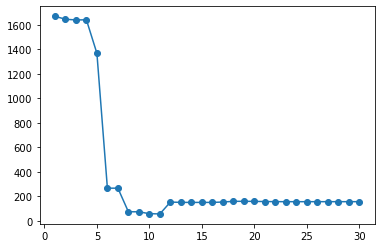

In [27]:
errors = CV_score(X,Y,K=10)
plt.plot(np.arange(X.shape[1] * Y.shape[1], 0, -1), np.sqrt(errors), '-o')
plt.show()

In [28]:
mask = None
N = X.shape[1] * Y.shape[1]
for i in range(N-5):
    C, mask = SSR(X, Y, mask)

model = ps.SINDy(feature_names=["x", "y", "z"], feature_library = ps.PolynomialLibrary(degree = 2))
model.fit(time_series, t=dt)   

print(C)
model.print()

[[ 0.          0.          0.        ]
 [-9.83141667 25.85503175  0.        ]
 [ 9.96982956  0.          0.        ]
 [ 0.          0.         -2.21482571]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.99706263]
 [ 0.         -0.95693727  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
x' = -0.218 1 + -9.831 x + 9.970 y
y' = 25.244 x + 0.260 y + -0.945 x z
z' = -11.143 1 + -2.215 z + 0.997 x y


$$
\dot{x} = 10 (y - x) \\
\dot{y} = x (28 - z) - y \\
\dot{z} = xy - \frac{8}{3} z
$$